# 🤖 Telco Customer Churn - Machine Learning Models

This notebook builds and evaluates multiple machine learning models for churn prediction.

**Objectives**:
- Train multiple ML algorithms
- Compare model performance
- Select best performing model
- Analyze feature importance
- Create production-ready prediction system

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, f1_score, accuracy_score, precision_score, recall_score
)
from sklearn.preprocessing import StandardScaler
import joblib
import warnings
warnings.filterwarnings('ignore')

print("🤖 Machine Learning Libraries Loaded!")

🤖 Machine Learning Libraries Loaded!


## 📥 Load Processed Data

In [2]:
# Load the processed dataset
try:
    df = pd.read_csv('../data/telco_processed_features.csv')
    print(f"✅ Dataset loaded: {df.shape}")
except FileNotFoundError:
    print("❌ Processed dataset not found. Please run 02_feature_engineering.ipynb first")
    df = None

if df is not None:
    print(f"\n📊 Dataset overview:")
    print(f"Samples: {len(df):,}")
    print(f"Features: {df.shape[1] - 1}")  # -1 for target column
    print(f"Churn rate: {df['Churn_Binary'].mean():.2%}")
    print(f"\nTarget distribution:")
    print(df['Churn_Binary'].value_counts())

✅ Dataset loaded: (7043, 25)

📊 Dataset overview:
Samples: 7,043
Features: 24
Churn rate: 26.54%

Target distribution:
Churn_Binary
0    5174
1    1869
Name: count, dtype: int64


## 🎯 Prepare Data for Modeling

In [3]:
# Prepare features and target
print("🎯 PREPARING DATA FOR MODELING")

if df is not None:
    # Separate features and target
    X = df.drop(['Churn_Binary'], axis=1)
    y = df['Churn_Binary']
    
    print(f"Features shape: {X.shape}")
    print(f"Target shape: {y.shape}")
    print(f"Feature names: {list(X.columns)}")
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"\n📊 Data split:")
    print(f"Training set: {X_train.shape[0]:,} samples")
    print(f"Test set: {X_test.shape[0]:,} samples")
    print(f"Training churn rate: {y_train.mean():.2%}")
    print(f"Test churn rate: {y_test.mean():.2%}")
    
    # Scale features for algorithms that need it
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"\n✅ Data prepared for modeling")

🎯 PREPARING DATA FOR MODELING
Features shape: (7043, 24)
Target shape: (7043,)
Feature names: ['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PaperlessBilling', 'MonthlyCharges', 'ServicePenetration', 'ChargesTenureRatio', 'LongTermContract', 'gender_Male', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes', 'Contract_One year', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']

📊 Data split:
Training set: 5,634 samples
Test set: 1,409 samples
Training churn rate: 26.54%
Test churn rate: 26.54%

✅ Data prepared for modeling


## 🏗️ Model Training and Evaluation

In [4]:
# Define models to train
print("🏗️ TRAINING MULTIPLE MODELS")

if X_train is not None:
    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'SVM': SVC(random_state=42, probability=True),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Naive Bayes': GaussianNB(),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'AdaBoost': AdaBoostClassifier(random_state=42)
    }
    
    # Models that need scaled features
    scaled_models = ['Logistic Regression', 'SVM', 'K-Nearest Neighbors', 'Naive Bayes']
    
    # Store results
    results = {}
    
    # Cross-validation setup
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    print("\n🔄 Training and evaluating models...")
    
    for name, model in models.items():
        print(f"\n📈 Training {name}...")
        
        # Choose appropriate data
        if name in scaled_models:
            X_train_model = X_train_scaled
            X_test_model = X_test_scaled
        else:
            X_train_model = X_train
            X_test_model = X_test
        
        # Train model
        model.fit(X_train_model, y_train)
        
        # Cross-validation scores
        cv_scores = cross_val_score(model, X_train_model, y_train, cv=cv, scoring='roc_auc')
        
        # Test predictions
        y_pred = model.predict(X_test_model)
        y_pred_proba = model.predict_proba(X_test_model)[:, 1]
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        # Store results
        results[name] = {
            'model': model,
            'cv_scores': cv_scores,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba,
            'scaled_data': name in scaled_models
        }
        
        print(f"  CV ROC-AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
        print(f"  Test ROC-AUC: {roc_auc:.3f}")
        print(f"  Test Accuracy: {accuracy:.3f}")
        print(f"  Test F1-Score: {f1:.3f}")
    
    print("\n✅ All models trained and evaluated!")

🏗️ TRAINING MULTIPLE MODELS

🔄 Training and evaluating models...

📈 Training Logistic Regression...
  CV ROC-AUC: 0.848 (+/- 0.022)
  Test ROC-AUC: 0.845
  Test Accuracy: 0.807
  Test F1-Score: 0.590

📈 Training Random Forest...
  CV ROC-AUC: 0.823 (+/- 0.026)
  Test ROC-AUC: 0.820
  Test Accuracy: 0.781
  Test F1-Score: 0.539

📈 Training Gradient Boosting...
  CV ROC-AUC: 0.848 (+/- 0.025)
  Test ROC-AUC: 0.843
  Test Accuracy: 0.796
  Test F1-Score: 0.567

📈 Training SVM...
  CV ROC-AUC: 0.804 (+/- 0.030)
  Test ROC-AUC: 0.807
  Test Accuracy: 0.798
  Test F1-Score: 0.566

📈 Training K-Nearest Neighbors...
  CV ROC-AUC: 0.773 (+/- 0.008)
  Test ROC-AUC: 0.773
  Test Accuracy: 0.767
  Test F1-Score: 0.539

📈 Training Naive Bayes...
  CV ROC-AUC: 0.831 (+/- 0.014)
  Test ROC-AUC: 0.827
  Test Accuracy: 0.765
  Test F1-Score: 0.618

📈 Training Decision Tree...
  CV ROC-AUC: 0.651 (+/- 0.037)
  Test ROC-AUC: 0.663
  Test Accuracy: 0.733
  Test F1-Score: 0.504

📈 Training AdaBoost...
  CV

## 📊 Model Performance Comparison

In [5]:
# Compare model performance
print("📊 MODEL PERFORMANCE COMPARISON")

if results:
    # Create performance comparison dataframe
    performance_df = pd.DataFrame({
        'Model': list(results.keys()),
        'CV_ROC_AUC_Mean': [results[name]['cv_mean'] for name in results.keys()],
        'CV_ROC_AUC_Std': [results[name]['cv_std'] for name in results.keys()],
        'Test_Accuracy': [results[name]['accuracy'] for name in results.keys()],
        'Test_Precision': [results[name]['precision'] for name in results.keys()],
        'Test_Recall': [results[name]['recall'] for name in results.keys()],
        'Test_F1_Score': [results[name]['f1_score'] for name in results.keys()],
        'Test_ROC_AUC': [results[name]['roc_auc'] for name in results.keys()]
    }).round(4)
    
    # Sort by Test ROC-AUC
    performance_df = performance_df.sort_values('Test_ROC_AUC', ascending=False)
    
    print("\n🏆 Model Performance Rankings:")
    print(performance_df)
    
    # Save performance comparison
    performance_df.to_csv('../data/model_performance_comparison.csv', index=False)
    print("\n💾 Performance comparison saved as '../data/model_performance_comparison.csv'")
    
    # Identify best model
    best_model_name = performance_df.iloc[0]['Model']
    best_model = results[best_model_name]['model']
    best_roc_auc = performance_df.iloc[0]['Test_ROC_AUC']
    
    print(f"\n🥇 Best Model: {best_model_name}")
    print(f"   ROC-AUC Score: {best_roc_auc:.4f}")
    print(f"   Accuracy: {performance_df.iloc[0]['Test_Accuracy']:.4f}")
    print(f"   F1-Score: {performance_df.iloc[0]['Test_F1_Score']:.4f}")

📊 MODEL PERFORMANCE COMPARISON

🏆 Model Performance Rankings:
                 Model  CV_ROC_AUC_Mean  CV_ROC_AUC_Std  Test_Accuracy  \
0  Logistic Regression           0.8483          0.0112         0.8070   
2    Gradient Boosting           0.8480          0.0124         0.7963   
7             AdaBoost           0.8468          0.0112         0.7928   
5          Naive Bayes           0.8314          0.0071         0.7651   
1        Random Forest           0.8233          0.0129         0.7814   
3                  SVM           0.8039          0.0149         0.7977   
4  K-Nearest Neighbors           0.7733          0.0040         0.7672   
6        Decision Tree           0.6510          0.0183         0.7331   

   Test_Precision  Test_Recall  Test_F1_Score  Test_ROC_AUC  
0          0.6759       0.5241         0.5904        0.8448  
2          0.6505       0.5027         0.5671        0.8425  
7          0.6367       0.5107         0.5668        0.8377  
5          0.5436      

## 📈 Model Performance Visualizations

📈 CREATING PERFORMANCE VISUALIZATIONS


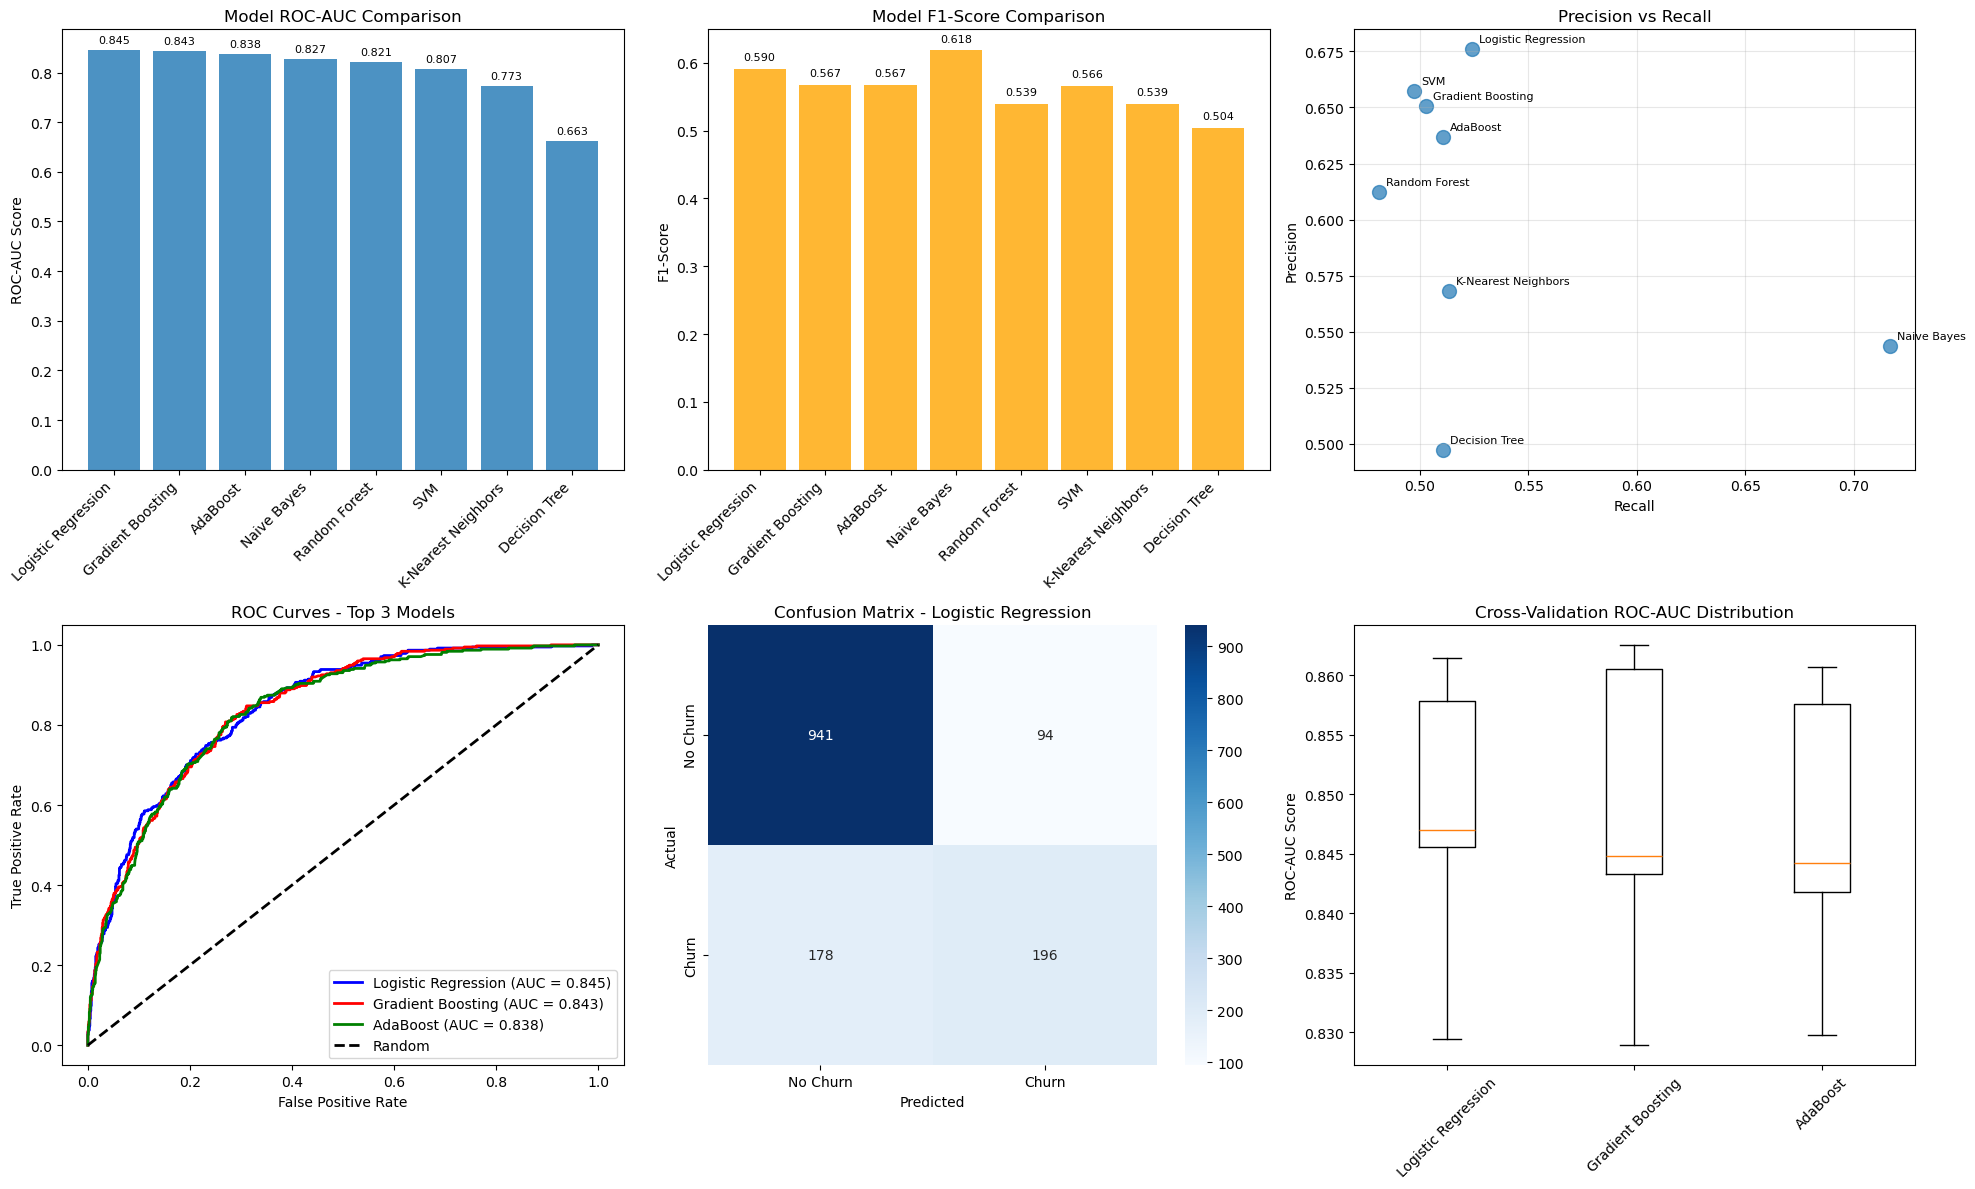

✅ Performance visualizations saved as '../visualizations/model_performance_dashboard.png'


In [6]:
# Create comprehensive performance visualizations
print("📈 CREATING PERFORMANCE VISUALIZATIONS")

if results and performance_df is not None:
    # Create a comprehensive performance dashboard
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. ROC-AUC Comparison
    model_names = performance_df['Model']
    roc_scores = performance_df['Test_ROC_AUC']
    
    bars1 = axes[0,0].bar(range(len(model_names)), roc_scores, alpha=0.8)
    axes[0,0].set_title('Model ROC-AUC Comparison')
    axes[0,0].set_ylabel('ROC-AUC Score')
    axes[0,0].set_xticks(range(len(model_names)))
    axes[0,0].set_xticklabels(model_names, rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, score in zip(bars1, roc_scores):
        axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                      f'{score:.3f}', ha='center', va='bottom', fontsize=8)
    
    # 2. F1-Score Comparison
    f1_scores = performance_df['Test_F1_Score']
    bars2 = axes[0,1].bar(range(len(model_names)), f1_scores, alpha=0.8, color='orange')
    axes[0,1].set_title('Model F1-Score Comparison')
    axes[0,1].set_ylabel('F1-Score')
    axes[0,1].set_xticks(range(len(model_names)))
    axes[0,1].set_xticklabels(model_names, rotation=45, ha='right')
    
    # Add value labels
    for bar, score in zip(bars2, f1_scores):
        axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                      f'{score:.3f}', ha='center', va='bottom', fontsize=8)
    
    # 3. Precision vs Recall
    precision_scores = performance_df['Test_Precision']
    recall_scores = performance_df['Test_Recall']
    
    axes[0,2].scatter(recall_scores, precision_scores, s=100, alpha=0.7)
    for i, model in enumerate(model_names):
        axes[0,2].annotate(model, (recall_scores.iloc[i], precision_scores.iloc[i]),
                          xytext=(5, 5), textcoords='offset points', fontsize=8)
    axes[0,2].set_xlabel('Recall')
    axes[0,2].set_ylabel('Precision')
    axes[0,2].set_title('Precision vs Recall')
    axes[0,2].grid(True, alpha=0.3)
    
    # 4. ROC Curves for top 3 models
    top_3_models = performance_df.head(3)['Model'].tolist()
    colors = ['blue', 'red', 'green']
    
    for i, model_name in enumerate(top_3_models):
        y_pred_proba = results[model_name]['y_pred_proba']
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = results[model_name]['roc_auc']
        
        axes[1,0].plot(fpr, tpr, color=colors[i], lw=2,
                      label=f'{model_name} (AUC = {roc_auc:.3f})')
    
    axes[1,0].plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
    axes[1,0].set_xlabel('False Positive Rate')
    axes[1,0].set_ylabel('True Positive Rate')
    axes[1,0].set_title('ROC Curves - Top 3 Models')
    axes[1,0].legend()
    
    # 5. Confusion Matrix for Best Model
    y_pred_best = results[best_model_name]['y_pred']
    cm = confusion_matrix(y_test, y_pred_best)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,1],
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    axes[1,1].set_title(f'Confusion Matrix - {best_model_name}')
    axes[1,1].set_ylabel('Actual')
    axes[1,1].set_xlabel('Predicted')
    
    # 6. Cross-validation scores distribution
    cv_data = []
    cv_labels = []
    
    for model_name in top_3_models:
        cv_data.append(results[model_name]['cv_scores'])
        cv_labels.append(model_name)
    
    axes[1,2].boxplot(cv_data, labels=cv_labels)
    axes[1,2].set_title('Cross-Validation ROC-AUC Distribution')
    axes[1,2].set_ylabel('ROC-AUC Score')
    axes[1,2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('../visualizations/model_performance_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Performance visualizations saved as '../visualizations/model_performance_dashboard.png'")

## 🔍 Feature Importance Analysis

🔍 FEATURE IMPORTANCE ANALYSIS

⚠️ Logistic Regression does not provide feature importance scores
Feature importance analysis not available for this model type

📊 Feature Coefficients for Logistic Regression:

Top 15 Features by Absolute Coefficient:
                           feature  coefficient  abs_coefficient
5                   MonthlyCharges    -0.892978         0.892978
8                 LongTermContract    -0.820164         0.820164
12     InternetService_Fiber optic     0.761851         0.761851
13              InternetService_No    -0.518098         0.518098
3                           tenure    -0.478711         0.478711
7               ChargesTenureRatio     0.373867         0.373867
20               Contract_One year     0.358057         0.358057
11               MultipleLines_Yes     0.262925         0.262925
19             StreamingMovies_Yes     0.262577         0.262577
18                 StreamingTV_Yes     0.256189         0.256189
4                 PaperlessBilling 

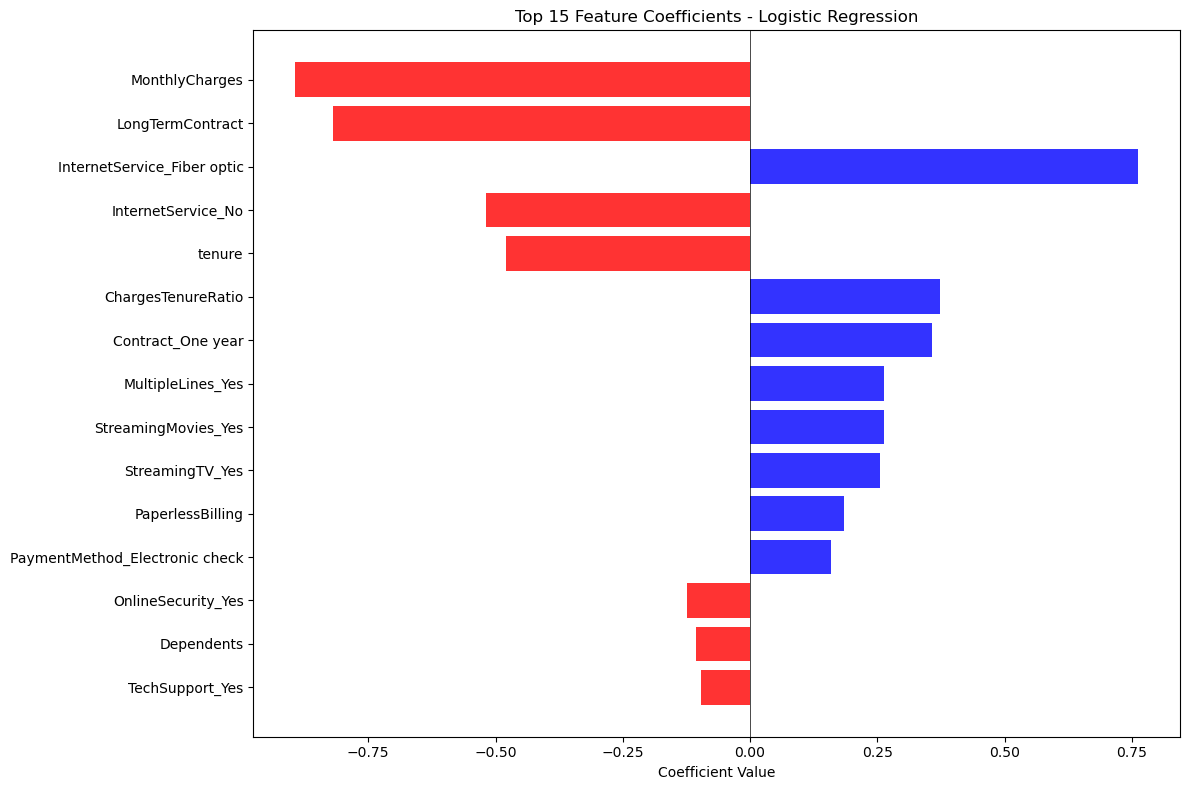


💾 Feature coefficients saved as '../data/feature_coefficients.csv'


In [7]:
# Feature importance analysis for tree-based models
print("🔍 FEATURE IMPORTANCE ANALYSIS")

if results and hasattr(best_model, 'feature_importances_'):
    print(f"\n📊 Feature Importance for {best_model_name}:")
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 15 Most Important Features:")
    print(feature_importance.head(15))
    
    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    
    plt.barh(range(len(top_features)), top_features['importance'], alpha=0.8)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Feature Importance - {best_model_name}')
    plt.gca().invert_yaxis()
    
    # Add value labels
    for i, importance in enumerate(top_features['importance']):
        plt.text(importance + 0.001, i, f'{importance:.3f}', 
                va='center', fontsize=8)
    
    plt.tight_layout()
    plt.savefig('../visualizations/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save feature importance
    feature_importance.to_csv('../data/feature_importance.csv', index=False)
    print("\n💾 Feature importance saved as '../data/feature_importance.csv'")
    
elif results:
    print(f"\n⚠️ {best_model_name} does not provide feature importance scores")
    print("Feature importance analysis not available for this model type")
    
    # For linear models, we can check coefficients
    if hasattr(best_model, 'coef_'):
        print(f"\n📊 Feature Coefficients for {best_model_name}:")
        
        feature_coef = pd.DataFrame({
            'feature': X.columns,
            'coefficient': best_model.coef_[0]
        })
        feature_coef['abs_coefficient'] = abs(feature_coef['coefficient'])
        feature_coef = feature_coef.sort_values('abs_coefficient', ascending=False)
        
        print("\nTop 15 Features by Absolute Coefficient:")
        print(feature_coef.head(15))
        
        # Visualize coefficients
        plt.figure(figsize=(12, 8))
        top_coef = feature_coef.head(15)
        colors = ['red' if x < 0 else 'blue' for x in top_coef['coefficient']]
        
        plt.barh(range(len(top_coef)), top_coef['coefficient'], color=colors, alpha=0.8)
        plt.yticks(range(len(top_coef)), top_coef['feature'])
        plt.xlabel('Coefficient Value')
        plt.title(f'Top 15 Feature Coefficients - {best_model_name}')
        plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        plt.gca().invert_yaxis()
        
        plt.tight_layout()
        plt.savefig('../visualizations/feature_coefficients.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Save coefficients
        feature_coef.to_csv('../data/feature_coefficients.csv', index=False)
        print("\n💾 Feature coefficients saved as '../data/feature_coefficients.csv'")

## ⚙️ Hyperparameter Tuning for Best Model

In [8]:
# Hyperparameter tuning for the best model
print("⚙️ HYPERPARAMETER TUNING")

if results and best_model_name:
    print(f"\n🔧 Tuning hyperparameters for {best_model_name}...")
    
    # Define parameter grids for different models
    param_grids = {
        'Random Forest': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        'Gradient Boosting': {
            'n_estimators': [100, 200],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2]
        },
        'Logistic Regression': {
            'C': [0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        },
        'SVM': {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'linear'],
            'gamma': ['scale', 'auto']
        }
    }
    
    if best_model_name in param_grids:
        # Get the appropriate training data
        if results[best_model_name]['scaled_data']:
            X_train_tune = X_train_scaled
            X_test_tune = X_test_scaled
        else:
            X_train_tune = X_train
            X_test_tune = X_test
        
        # Create a fresh model instance
        model_class = type(best_model)
        fresh_model = model_class(random_state=42)
        
        # Grid search with cross-validation
        grid_search = GridSearchCV(
            fresh_model,
            param_grids[best_model_name],
            cv=5,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=1
        )
        
        print("🔄 Running grid search (this may take a few minutes)...")
        grid_search.fit(X_train_tune, y_train)
        
        # Get best model
        best_tuned_model = grid_search.best_estimator_
        
        # Evaluate tuned model
        y_pred_tuned = best_tuned_model.predict(X_test_tune)
        y_pred_proba_tuned = best_tuned_model.predict_proba(X_test_tune)[:, 1]
        
        tuned_roc_auc = roc_auc_score(y_test, y_pred_proba_tuned)
        tuned_f1 = f1_score(y_test, y_pred_tuned)
        
        print(f"\n🏆 HYPERPARAMETER TUNING RESULTS:")
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best CV score: {grid_search.best_score_:.4f}")
        print(f"\nOriginal model performance:")
        print(f"  ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")
        print(f"  F1-Score: {results[best_model_name]['f1_score']:.4f}")
        print(f"\nTuned model performance:")
        print(f"  ROC-AUC: {tuned_roc_auc:.4f}")
        print(f"  F1-Score: {tuned_f1:.4f}")
        
        # Update best model if tuned version is better
        if tuned_roc_auc > results[best_model_name]['roc_auc']:
            print(f"\n✅ Tuned model performs better! Using tuned version.")
            best_model = best_tuned_model
            results[best_model_name]['model'] = best_tuned_model
            results[best_model_name]['roc_auc'] = tuned_roc_auc
            results[best_model_name]['f1_score'] = tuned_f1
            results[best_model_name]['y_pred'] = y_pred_tuned
            results[best_model_name]['y_pred_proba'] = y_pred_proba_tuned
        else:
            print(f"\n📊 Original model performs better. Keeping original version.")
    
    else:
        print(f"\n⚠️ No parameter grid defined for {best_model_name}")
        print("Skipping hyperparameter tuning")

⚙️ HYPERPARAMETER TUNING

🔧 Tuning hyperparameters for Logistic Regression...
🔄 Running grid search (this may take a few minutes)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


/Users/kaushiktummalapalli/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kaushiktummalapalli/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kaushiktummalapalli/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kaushiktummalapalli/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kaushiktummalapalli/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w


🏆 HYPERPARAMETER TUNING RESULTS:
Best parameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV score: 0.8484

Original model performance:
  ROC-AUC: 0.8448
  F1-Score: 0.5904

Tuned model performance:
  ROC-AUC: 0.8436
  F1-Score: 0.5852

📊 Original model performs better. Keeping original version.


## 💾 Save Best Model

In [9]:
# Save the best model and related components
print("💾 SAVING BEST MODEL")

if results and best_model:
    # Save the best model
    model_filename = f'../models/best_churn_model_{best_model_name.lower().replace(" ", "_")}.pkl'
    joblib.dump(best_model, model_filename)
    print(f"✅ Best model saved as '{model_filename}'")
    
    # Save the scaler if needed
    if results[best_model_name]['scaled_data']:
        joblib.dump(scaler, '../models/feature_scaler.pkl')
        print("✅ Feature scaler saved as '../models/feature_scaler.pkl'")
    
    # Save feature names
    feature_names = list(X.columns)
    joblib.dump(feature_names, '../models/feature_names.pkl')
    print("✅ Feature names saved as '../models/feature_names.pkl'")
    
    # Save model metadata
    model_metadata = {
        'model_name': best_model_name,
        'model_type': type(best_model).__name__,
        'requires_scaling': results[best_model_name]['scaled_data'],
        'roc_auc_score': results[best_model_name]['roc_auc'],
        'f1_score': results[best_model_name]['f1_score'],
        'accuracy': results[best_model_name]['accuracy'],
        'precision': results[best_model_name]['precision'],
        'recall': results[best_model_name]['recall'],
        'features_count': len(feature_names),
        'training_samples': len(X_train),
        'test_samples': len(X_test)
    }
    
    pd.DataFrame([model_metadata]).to_csv('../models/model_metadata.csv', index=False)
    print("✅ Model metadata saved as '../models/model_metadata.csv'")
    
    print(f"\n🎯 FINAL MODEL SUMMARY:")
    print(f"✅ Best Model: {best_model_name}")
    print(f"✅ ROC-AUC Score: {results[best_model_name]['roc_auc']:.4f}")
    print(f"✅ F1-Score: {results[best_model_name]['f1_score']:.4f}")
    print(f"✅ Accuracy: {results[best_model_name]['accuracy']:.4f}")
    print(f"✅ Features: {len(feature_names)}")
    print(f"✅ Requires Scaling: {results[best_model_name]['scaled_data']}")
    
    print(f"\n📊 BUSINESS IMPACT ESTIMATION:")
    
    # Calculate business metrics
    total_test_customers = len(y_test)
    actual_churners = y_test.sum()
    predicted_churners = results[best_model_name]['y_pred'].sum()
    
    # True positives (correctly identified churners)
    true_positives = ((y_test == 1) & (results[best_model_name]['y_pred'] == 1)).sum()
    
    print(f"📈 Test set size: {total_test_customers:,} customers")
    print(f"📉 Actual churners: {actual_churners:,} customers")
    print(f"🎯 Predicted churners: {predicted_churners:,} customers")
    print(f"✅ Correctly identified churners: {true_positives:,} customers")
    print(f"📊 Churn detection rate: {true_positives/actual_churners:.1%}")
    
    print("\n🚀 Next step: Run notebook 05_model_evaluation.ipynb for detailed analysis")

💾 SAVING BEST MODEL
✅ Best model saved as '../models/best_churn_model_logistic_regression.pkl'
✅ Feature scaler saved as '../models/feature_scaler.pkl'
✅ Feature names saved as '../models/feature_names.pkl'
✅ Model metadata saved as '../models/model_metadata.csv'

🎯 FINAL MODEL SUMMARY:
✅ Best Model: Logistic Regression
✅ ROC-AUC Score: 0.8448
✅ F1-Score: 0.5904
✅ Accuracy: 0.8070
✅ Features: 24
✅ Requires Scaling: True

📊 BUSINESS IMPACT ESTIMATION:
📈 Test set size: 1,409 customers
📉 Actual churners: 374 customers
🎯 Predicted churners: 290 customers
✅ Correctly identified churners: 196 customers
📊 Churn detection rate: 52.4%

🚀 Next step: Run notebook 05_model_evaluation.ipynb for detailed analysis
